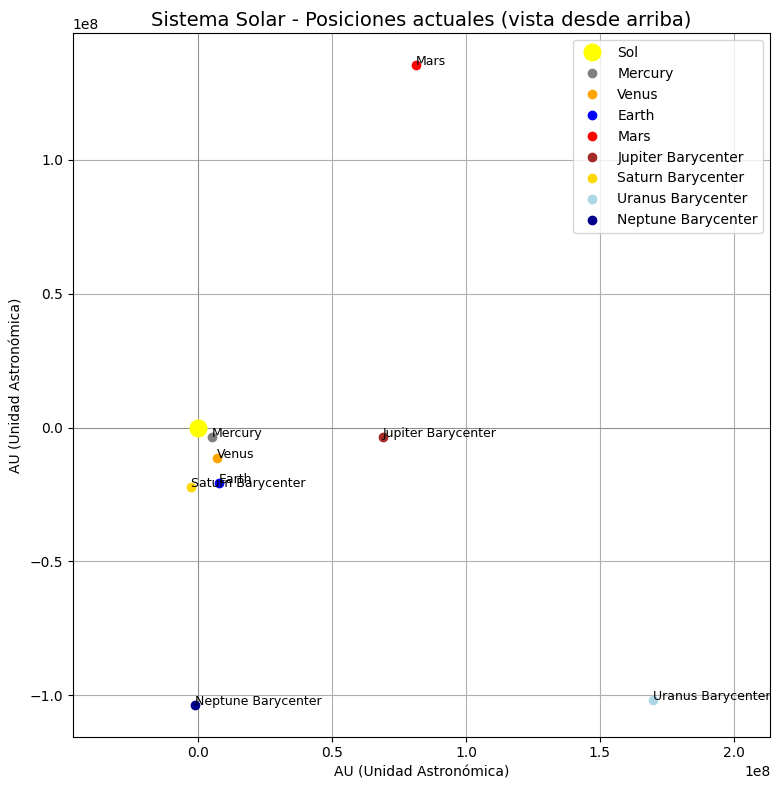

In [6]:
from skyfield.api import load
import matplotlib.pyplot as plt

# Cargar efemérides y tiempos
eph = load('de421.bsp')  # Usa el archivo de efemérides del JPL
ts = load.timescale()
t = ts.now()

# Planetas a incluir
planetas = ['mercury', 'venus', 'earth', 'mars', 'jupiter barycenter', 'saturn barycenter', 'uranus barycenter', 'neptune barycenter']

# Colores y etiquetas para graficar
colores = ['gray', 'orange', 'blue', 'red', 'brown', 'gold', 'lightblue', 'darkblue']

# Obtener posiciones heliocéntricas
posiciones = []
for nombre in planetas:
    planeta = eph[nombre]
    pos = eph['sun'].at(t).observe(planeta).apparent().position.au
    posiciones.append((nombre.title(), pos[0], pos[1]))

# Crear el gráfico
plt.figure(figsize=(8, 8))
plt.title("Sistema Solar - Posiciones actuales (vista desde arriba)", fontsize=14)
plt.xlabel("AU (Unidad Astronómica)")
plt.ylabel("AU (Unidad Astronómica)")
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

# Dibujar el Sol en el centro
plt.plot(0, 0, 'o', color='yellow', markersize=12, label='Sol')

# Dibujar los planetas
for i, (nombre, x, y) in enumerate(posiciones):
    plt.plot(x, y, 'o', color=colores[i], label=nombre)
    plt.text(x + 0.05, y + 0.05, nombre, fontsize=9)
max_range = max(max(abs(x), abs(y)) for _, x, y in posiciones) + 1  # Margen visual
plt.xlim(-max_range, max_range)
plt.ylim(-max_range, max_range)
plt.xlim(-2.5E8, 2.5E8)
plt.ylim(-2.5, 2.5)
plt.axis('equal')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [8]:
pip install skyfield

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


OSError: cannot download https://ssd.jpl.nasa.gov/ftp/eph/planets/bsp/asteroids.bsp because HTTP Error 404: Not Found

In [12]:
pip install astroquery skyfield

Defaulting to user installation because normal site-packages is not writeable
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:00
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


🔭 Asteroides detectados a < 0.25 AU: 319
⚠️ Error con KU: Ambiguous target name; provide unique id:
  ID#      Name                               Designation  IAU/aliases/other   
  -------  ---------------------------------- -----------  ------------------- 
  -937016  2023 PDC (simulation)                           PDC23                
  -937017  2023 PDCa (simulation)                          PDC23a               
  -937018  2023 PDCf (simulation)                          PDC23f               
  -937024  2023 TTX (simulation)              TTX23 TTX24 T2024 TTX             
  -999789  2023 NM (debris)                                                     
 
⚠️ Error con JM2: Ambiguous target name; provide unique id:
  ID#      Name                               Designation  IAU/aliases/other   
  -------  ---------------------------------- -----------  ------------------- 
  -937019  2024 PDC25 (simulation)                         PDC25 PDC24          
  -937020  2024 PDC25a (simulati

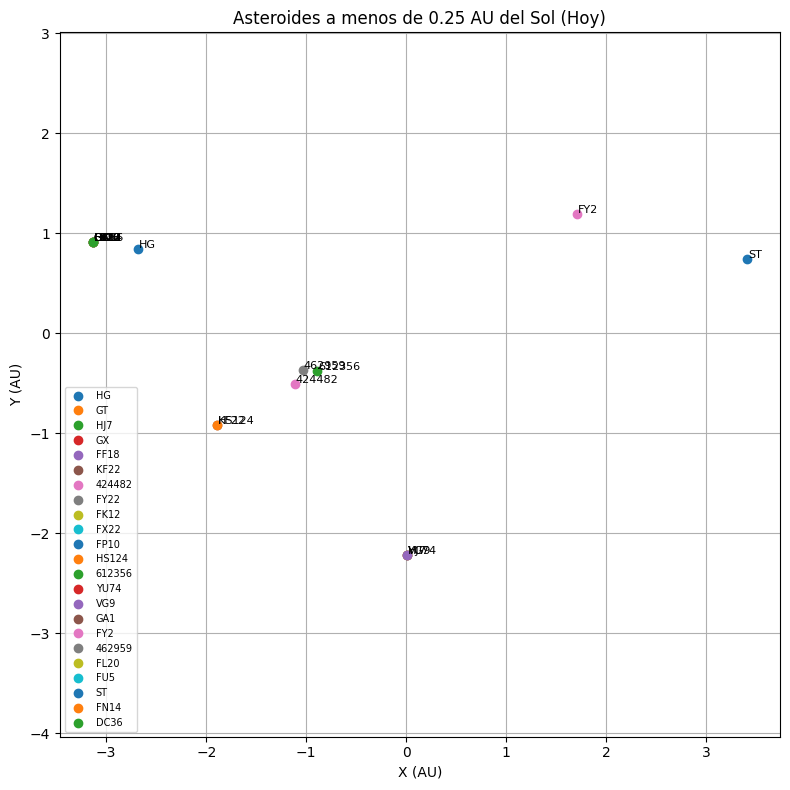

In [19]:
import requests
from astroquery.jplhorizons import Horizons
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

# 1. Fecha actual (hoy)
today = Time.now().strftime('%Y-%m-%d')

# 2. Llamar a la API CAD de JPL para obtener asteroides < 0.25 AU
url = "https://ssd-api.jpl.nasa.gov/cad.api"
params = {
    'dist-max': '0.25',
   # 'date-min': today,
  #  'date-max': today,
    'sort': 'dist',
    'limit': '1000',
    'body': 'Earth',
    'fullname': 'true'
}

response = requests.get(url, params=params)
data = response.json()

# 3. Extraer los desigs (identificadores de Horizons)
asteroides = {}
for entry in data['data']:
    desig = entry[0]  # ej: '99942 Apophis'
    if ' ' in desig:
        nombre = desig.split(' ', 1)[1]
        id_horizons = desig.split(' ', 1)[0]
    else:
        nombre = desig
        id_horizons = desig
    asteroides[nombre] = id_horizons

print(f"🔭 Asteroides detectados a < 0.25 AU: {len(asteroides)}")

# 4. Obtener posiciones actuales desde el Sol
jd = Time.now().jd
posiciones = {}

for nombre, id_h in list(asteroides.items())[:30]:  # Limitamos a 30 para no saturar
    try:
        obj = Horizons(id=id_h, location='500@10', epochs=jd)
        vec = obj.vectors()
        x, y = vec['x'][0], vec['y'][0]
        posiciones[nombre] = (x, y)
    except Exception as e:
        print(f"⚠️ Error con {nombre}: {e}")

# 5. Graficar
plt.figure(figsize=(8, 8))
for i, (nombre, (x, y)) in enumerate(posiciones.items()):
    plt.plot(x, y, 'o', label=nombre)
    plt.text(x + 0.01, y + 0.01, nombre, fontsize=8)

plt.title("Asteroides a menos de 0.25 AU del Sol (Hoy)")
plt.xlabel("X (AU)")
plt.ylabel("Y (AU)")
plt.grid(True)
plt.axis('equal')
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

In [18]:
data

{'signature': {'version': '1.5',
  'source': 'NASA/JPL SBDB Close Approach Data API'},
 'total': 0,
 'count': 0}